## Increased variance (heteroscedasticity) in estimated effect size at SNPs with lower allele frequencies reduces the ability to call disease-associated SNPs, even though the underlying model (inferring effect sizes) is correct



In [1]:
import numpy as np # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.metrics import precision_recall_curve # type: ignore

import matplotlib.pyplot as plt # type: ignore

plt.rcParams.update({'font.size': 20}) 

def simulate_genotype_and_phenotype_at_given_snp(is_high_freq_snp, n_samples, is_disease_associated):
    true_effect_size = 1  # Effect size of disease-associated SNPs

    high_freq = 0.5  # Allele frequency of high-frequency SNPs
    low_freq = 0.1  # Allele frequency of low-frequency SNPs

    freq = high_freq if is_high_freq_snp else low_freq

    genotype = np.random.binomial(2, freq, n_samples)
    intercept = -2  # Baseline log-odds for disease
    effect_size = true_effect_size if is_disease_associated else 0
    log_odds = intercept + effect_size * genotype
    disease_prob = 1 / (1 + np.exp(-log_odds))
    disease = np.random.binomial(1, disease_prob)

    return genotype, disease

def simulate_genotype_and_phenotype_at_all_snps(): 
    # Seed for reproducibility
    np.random.seed(42)

    n_snps = 10000  # Total number of SNPs

    # identify SNPs that are high or low frequency
    # The high- and low-frequency SNPs could represent the same SNPs in a given genomic regions, but in two different populations. 
    # Alternatively, they could represent SNPs in different genomic regions in the same population.
    n_high_freq_snps = n_snps // 2
    high_freq_snp_indices = np.random.choice(range(n_snps), size=n_high_freq_snps, replace=False)
    # low_freq_snp_indices = np.setdiff1d(range(n_snps), high_freq_snp_indices)

    # identify SNPs that are disease-associated
    n_disease_snps = n_snps // 2  
    disease_snp_indices = np.random.choice(range(n_snps), size=n_disease_snps, replace=False)
    # neutral_snp_indices = np.setdiff1d(range(n_snps), disease_snp_indices)

    n_samples = 100

    # Collect data for all SNPs
    genotypes = []
    disease_outcomes = []
    snp_high_freq = []
    snp_disease_associated = []

    for i in range(n_snps):
        is_high_freq_snp = i in high_freq_snp_indices
        is_disease_snp = i in disease_snp_indices
        genotype, disease = simulate_genotype_and_phenotype_at_given_snp(is_high_freq_snp, n_samples, is_disease_snp)
        genotypes.append(genotype)
        disease_outcomes.append(disease)
        snp_high_freq.append(is_high_freq_snp)
        snp_disease_associated.append(is_disease_snp)
    
    # Convert to numpy arrays for convenience
    genotypes = np.array(genotypes).T  # shape: (n_samples, n_snps)
    disease_outcomes = np.array(disease_outcomes).T  # Shape: (n_samples, n_snps)
    snp_high_freq = np.array(snp_high_freq)
    snp_disease_associated = np.array(snp_disease_associated)

    return genotypes, disease_outcomes, snp_high_freq, snp_disease_associated

In [2]:
from scipy.stats import chi2 # type: ignore

def compute_log_likelihood(X, y, model):
    probs = model.predict_proba(X)[:, 1]
    log_likelihood = np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    return log_likelihood

def run_gwas(genotypes, disease_outcomes, snp_high_freq, snp_disease_associated):
    alpha = 0.05  # Significance level

    power_high_freq = 0
    power_low_freq = 0
    effect_sizes_high_freq = []
    effect_sizes_low_freq = []
    snp_disease_associated_high_freq = []
    snp_disease_associated_low_freq = []

    n_samples = genotypes.shape[0]
    n_snps = genotypes.shape[1]
    
    for i in range(n_snps):
        X = genotypes[:, i].reshape(-1, 1)
        y = disease_outcomes[:, i]

        # Fit the logistic regression model with the SNP (the "alternative" model)
        model_alt = LogisticRegression()
        model_alt.fit(X, y)
        log_likelihood_alt = compute_log_likelihood(X, y, model_alt) 

        effect_size = model_alt.coef_[0][0]
        is_disease_snp = snp_disease_associated[i] 

        if snp_high_freq[i]:
            effect_sizes_high_freq.append(effect_size)
            snp_disease_associated_high_freq.append(is_disease_snp)
        else:
            effect_sizes_low_freq.append(effect_size)
            snp_disease_associated_low_freq.append(is_disease_snp)

        # Fit the logistic regression model without the SNP (the "null" model)
        model_null = LogisticRegression()
        ones = np.ones((n_samples, 1))
        model_null.fit(ones, y)
        log_likelihood_null = compute_log_likelihood(ones, y, model_null) 

        # c.f., https://gist.github.com/petermchale/5272f54dd51a1b6d51c41f9bbda6b56d
        # Compute the likelihood ratio statistic
        likelihood_ratio_stat = 2 * (log_likelihood_alt - log_likelihood_null)
        # Compute the p-value from the likelihood ratio statistic
        p_value = chi2.sf(likelihood_ratio_stat, df=1) # survival function (sf) is 1 - cdf

        if p_value < alpha and is_disease_snp:
            if snp_high_freq[i]:
                power_high_freq += 1
            else:
                power_low_freq += 1

    # c.f., https://nbviewer.org/gist/petermchale/b184b08fcafe430b401516e2b4776924
    number_high_freq_snps_that_are_disease_associated = np.sum(snp_high_freq & snp_disease_associated)
    number_low_freq_snps_that_are_disease_associated = np.sum(~snp_high_freq & snp_disease_associated)
    power_high_freq /= number_high_freq_snps_that_are_disease_associated
    power_low_freq /= number_low_freq_snps_that_are_disease_associated

    print(f"Power to detect disease-associated SNPs when they are at high allele frequency: {power_high_freq}")
    print(f"Power to detect disease-associated SNPs when they are at low allele frequency SNPs: {power_low_freq}")

    return effect_sizes_high_freq, effect_sizes_low_freq, snp_disease_associated_high_freq, snp_disease_associated_low_freq

In [3]:
def get_effect_sizes(es, ds, is_disease_associated): 
    return [
        e for e, d in zip(es, ds) 
        if d == is_disease_associated
    ]

def plot_effect_size_distributions(effect_sizes, snp_disease_associated, title):
    effect_sizes_disease_associated = get_effect_sizes(effect_sizes, snp_disease_associated, is_disease_associated=True)
    effect_sizes_not_disease_associated = get_effect_sizes(effect_sizes, snp_disease_associated, is_disease_associated=False)

    bins = 100 

    plt.figure(figsize=(10, 6))
    plt.hist(effect_sizes_disease_associated, bins=bins, alpha=0.5, label='Disease-associated SNPs')
    plt.hist(effect_sizes_not_disease_associated, bins=bins, alpha=0.5, label='Neutral SNPs')
    plt.xlabel('Inferred effect size')
    plt.ylabel('Number of SNPs')
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def plot_PR_curves(effect_sizes_high_freq, effect_sizes_low_freq, snp_disease_associated_high_freq, snp_disease_associated_low_freq):
    precision_high, recall_high, _ = precision_recall_curve(snp_disease_associated_high_freq, effect_sizes_high_freq) 
    precision_low, recall_low, _ = precision_recall_curve(snp_disease_associated_low_freq, effect_sizes_low_freq)

    plt.figure(figsize=(10, 6))
    plt.plot(recall_high, precision_high, label=f'High allele frequency')
    plt.plot(recall_low, precision_low, label=f'Low allele frequency')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('performace at the task of predicting whether a SNP\nis disease-associated based on its inferred effect size')
    plt.show()

Power to detect disease-associated SNPs when they are at high allele frequency: 0.860652436568667
Power to detect disease-associated SNPs when they are at low allele frequency SNPs: 0.3873659117997616


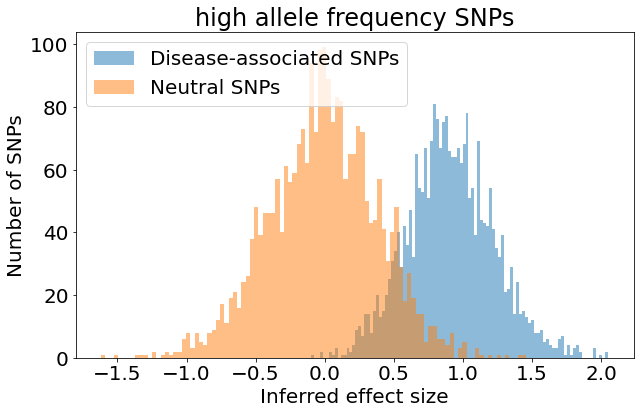

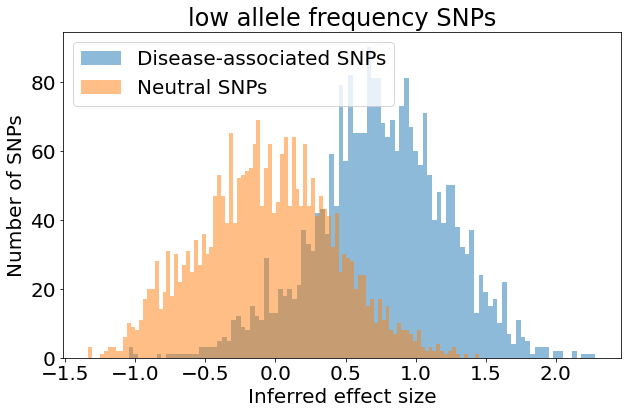

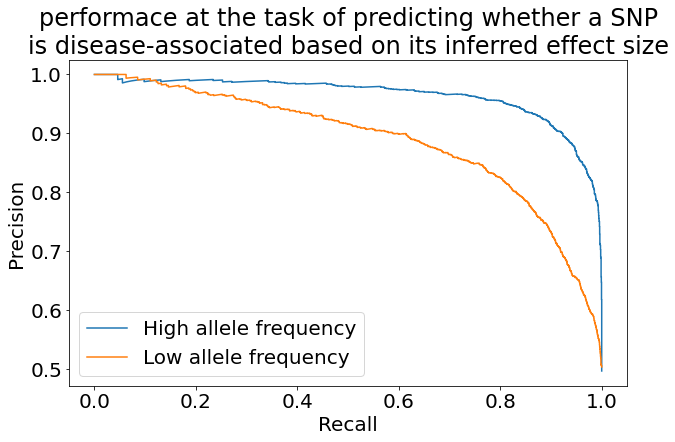

In [5]:
def main():
    genotypes, disease_outcomes, snp_high_freq, snp_disease_associated = simulate_genotype_and_phenotype_at_all_snps()
    effect_sizes_high_freq, effect_sizes_low_freq, snp_disease_associated_high_freq, snp_disease_associated_low_freq = run_gwas(
        genotypes, disease_outcomes, snp_high_freq, snp_disease_associated
    )
    plot_effect_size_distributions(effect_sizes_high_freq, snp_disease_associated_high_freq, 'high allele frequency SNPs')
    plot_effect_size_distributions(effect_sizes_low_freq, snp_disease_associated_low_freq, 'low allele frequency SNPs')
    plot_PR_curves(effect_sizes_high_freq, effect_sizes_low_freq, snp_disease_associated_high_freq, snp_disease_associated_low_freq)

main() 